In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy.linalg

In [72]:
class NumberLineSystem:
    """
    1D particle system with collision and potential field.

    State: x[t] = [y[t], v[t]]
    Input: u[t] ∈ [-1, 1]
    Output: z[t] = y[t] + measurement noise
    """

    def __init__(self, m=1, p_c=0.0, p_w=0.0, y_max=1.0, v_max=1.0, y0=0, v0=0, A=1, noise=True):
        self.m = m
        self.p_c = p_c
        self.p_w = p_w
        self.v_max = v_max
        self.y = y0
        self.v = v0 + self.d_v_noise(v0)

        self.noise = noise
        self.z = self.y

        """
        if self.noise is True:
          self.z += np.random.normal(0, 0.25*self.v**2)
        """

        self.history = {'y': [y0], 'v': [v0], 'u':[0], 'z': [self.z]}
        self.A = A # Amplitude
        self.y_max = y_max

    def d_v_noise(self, v):
        """
        Implements the d(v) function using numpy's choice function
        """
        speed = abs(v)

        outcomes = [1, 0, -1]

        p1 = (speed / self.v_max) * (self.p_w / 2)
        p0 = 1 - (speed / self.v_max) * self.p_w
        p_minus1 = (speed / self.v_max) * (self.p_w / 2)

        probabilities = [p1, p0, p_minus1]

        return np.random.choice(outcomes, p=probabilities)

    def f_phi(self, y):
        return int(self.A*np.sin(2*np.pi*y/self.y_max))

    def crash_probability(self, v):
        return self.p_c * abs(v) / self.v_max

    def calculate_state_space(self, u, y, v):
        # Apply collision dynamics
        p_crash = self.crash_probability(y)

        v_no_crash = v + (u + self.f_phi(y)) / self.m
        v_crash = 0
        outcomes = [v_no_crash, v_crash]

        # P(v_no_crash) = 1 - p_crash
        # P(v_crash) = p_crash

        probabilities = [1 - p_crash, p_crash]
        v = np.random.choice(outcomes, p=probabilities)

        if self.noise is True:
          v += self.d_v_noise(v)

        if abs(v) > self.v_max:
          v = np.sign(v) * self.v_max

        # Apply position dynamics
        y = y + v
        if abs(y) > self.y_max:
            y = np.sign(y) * self.y_max
        return y, v

    def edge_check(prev_y, prev_v, new_y, new_v, system=None):
        """
        Check if transition from (prev_y, prev_v) to (new_y, new_v) is possible with u in [-1, 1].

        Computes required u = m * (new_v - prev_v) - f_phi(prev_y)
        Simulates forward to verify new_y matches.

        Args:
        - prev_y, prev_v: Starting state.
        - new_y, new_v: Target state (z interpreted as new_v).
        - system: NumberLineSystem instance (for m, A, etc.; defaults to m=1, A=1 if None).

        Returns:
        - u (float) if valid (matches dynamics and |u| <=1), else None.
        """
        if system is None:
            m = 1.0
            A = 1.0
            y_max = 1.0
            v_max = 1.0
        else:
            m = system.m
            A = system.A
            y_max = system.y_max
            v_max = system.v_max

        # Compute required u for velocity update (deterministic, no crash)
        force_phi = A * np.sin(2 * np.pi * prev_y / y_max)
        u_required = m * (new_v - prev_v) - force_phi

        # Check if u in bounds
        if not (-1 <= u_required <= 1):
            return None

        # Simulate forward to verify position matches (with clamping)
        v_sim = new_v  # Use provided new_v
        if abs(v_sim) > v_max:
            v_sim = np.sign(v_sim) * v_max
        y_sim = prev_y + v_sim
        if abs(y_sim) > y_max:
            y_sim = np.sign(y_sim) * y_max

        # Check exact match (with tolerance for FP)
        if not np.isclose(y_sim, new_y, atol=1e-10):
            return None

        return float(u_required)


    def step(self, u):
        self.y, self.v = self.calculate_state_space(u, self.y, self.v)

        if abs(self.v) > self.v_max:
          print(self.v)

        # Update output
        self.z = self.y

        """
        if self.noise is True:
          self.z += np.random.normal(0, 0.25*self.v**2)
        """

        self.history['y'].append(self.y)
        self.history['z'].append(self.z)
        self.history['v'].append(self.v)
        self.history['u'].append(u)

    def simulate(self, inputs):
        # Reset history for a new simulation
        self.z = self.history['y'][0]
        if self.noise is True:
          self.z += np.random.normal(0, 0.25*self.history['v'][0]**2)

        self.history = {'y': [self.history['y'][0]], 'v': [self.history['v'][0]], 'u': [self.history['u'][0]], 'z': [self.z]}
        results = []
        for u in inputs:
            """
            if u not in [-1, 0, 1]:
              raise ValueError(f"Invalid input: {u}. Input must be -1, 0, or 1.")
            """
            results.append(self.step(u))

        # Save to a .csv file using pandas
        T = len(system.history['y'])
        df = pd.DataFrame({
            'Time': range(T),
            'Position_y': [f"{val:.4f}" for val in self.history['y']],
            'Velocity_v': [f"{val:.4f}" for val in self.history['v']],
            'Input_u': [f"{val:.4f}" for val in self.history['u']],
            'Output_z': [f"{val:.4f}" for val in self.history['z']]
        })
        df.to_csv('number_line_sim.csv', index=False)

        return results

In [73]:
"""
system = NumberLineSystem()    # instantiate the class
# input_seq = np.random.uniform(-1, 1, 10_000)     # generate some random inputs
input_seq = [1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1]
system.simulate(input_seq)                   # run simulation

T = len(system.history['y'])  # Number of (simulated) timesteps

plt.figure(figsize=(10,4))
plt.plot(range(T), system.history['y'], label='Position (y)')
plt.plot(range(T), system.history['z'], label='Output (z)')
plt.plot(range(T), system.history['v'], label='Velocity (v)')
plt.plot(range(T), system.history['u'], label='Input')
plt.xlabel('Time step')
plt.ylabel('System state')
plt.title('NumberLineSystem Simulation')
plt.legend()
plt.grid(True)
plt.show()
"""

"\nsystem = NumberLineSystem()    # instantiate the class\n# input_seq = np.random.uniform(-1, 1, 10_000)     # generate some random inputs\ninput_seq = [1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1]\nsystem.simulate(input_seq)                   # run simulation\n\nT = len(system.history['y'])  # Number of (simulated) timesteps\n\nplt.figure(figsize=(10,4))\nplt.plot(range(T), system.history['y'], label='Position (y)')\nplt.plot(range(T), system.history['z'], label='Output (z)')\nplt.plot(range(T), system.history['v'], label='Velocity (v)')\nplt.plot(range(T), system.history['u'], label='Input')\nplt.xlabel('Time step')\nplt.ylabel('System state')\nplt.title('NumberLineSystem Simulation')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [74]:
"""
def graph_search(resolution=10, input_resolution=10_000):
    input_u_points = np.linspace(-1, 1, input_resolution)
    numberlineSystem = NumberLineSystem()
    y_points = np.linspace(-numberlineSystem.y_max, numberlineSystem.y_max, resolution)
    v_points = np.linspace(-numberlineSystem.v_max, numberlineSystem.v_max, resolution)
    y_mesh, v_mesh = np.meshgrid(y_points, v_points)
    state_space = np.vstack((y_mesh.ravel(), v_mesh.ravel())).T

    # Tolerance for exact match (floating-point precision)
    tol = 1e-5

    transitions = []  # List to record all unique (prev, u, next) with exact matches
    for i, state in enumerate(state_space):
        current_y, current_v = state
        seen_next = set()
        for u in input_u_points:
            next_y, next_v = numberlineSystem.calculate_state_space(u, current_y, current_v)
            # Check for exact match to grid points
            y_match = np.isclose(y_points, next_y, atol=tol)
            v_match = np.isclose(v_points, next_v, atol=tol)
            if np.any(y_match) and np.any(v_match):
                next_y_grid = y_points[y_match][0]
                next_v_grid = v_points[v_match][0]
                # Find exact index in state_space
                next_i_candidates = np.where((np.isclose(state_space[:,0], next_y_grid, atol=tol)) &
                                             (np.isclose(state_space[:,1], next_v_grid, atol=tol)))[0]
                if len(next_i_candidates) == 1:
                    next_i = next_i_candidates[0]
                    if next_i not in seen_next:
                        transitions.append({
                            'prev_state': i,
                            'prev_y': current_y,
                            'prev_v': current_v,
                            'input_u': float(u),
                            'next_state': next_i,
                            'next_y': next_y_grid,
                            'next_v': next_v_grid
                        })
                        seen_next.add(next_i)

    return state_space, transitions

def print_visualization_table(state_space, transitions, max_rows=20):
    # Sample first N transitions for table
    sample_trans = transitions[:max_rows]

    # Create DataFrame for table
    df = pd.DataFrame({
        'Prev State': [f"{t['prev_state']}: ({t['prev_y']:.2f}, {t['prev_v']:.2f})" for t in sample_trans],
        'Input u': [f"{t['input_u']:.2f}" for t in sample_trans],
        'Next State': [f"{t['next_state']}: ({t['next_y']:.2f}, {t['next_v']:.2f})" for t in sample_trans]
    })

    # Summary
    total_trans = len(transitions)
    print(f"\nTotal unique exact transitions: {total_trans}")

# Usage
state_space, transitions = graph_search()
print_visualization_table(state_space, transitions)
"""

'\ndef graph_search(resolution=10, input_resolution=10_000):\n    input_u_points = np.linspace(-1, 1, input_resolution)\n    numberlineSystem = NumberLineSystem()\n    y_points = np.linspace(-numberlineSystem.y_max, numberlineSystem.y_max, resolution)\n    v_points = np.linspace(-numberlineSystem.v_max, numberlineSystem.v_max, resolution)\n    y_mesh, v_mesh = np.meshgrid(y_points, v_points)\n    state_space = np.vstack((y_mesh.ravel(), v_mesh.ravel())).T\n\n    # Tolerance for exact match (floating-point precision)\n    tol = 1e-5\n\n    transitions = []  # List to record all unique (prev, u, next) with exact matches\n    for i, state in enumerate(state_space):\n        current_y, current_v = state\n        seen_next = set()\n        for u in input_u_points:\n            next_y, next_v = numberlineSystem.calculate_state_space(u, current_y, current_v)\n            # Check for exact match to grid points\n            y_match = np.isclose(y_points, next_y, atol=tol)\n            v_match =

In [75]:
"""
# Build NetworkX graph
G = nx.DiGraph()
# Add nodes
for i in range(len(state_space)):
    G.add_node(i, pos=(state_space[i, 0], state_space[i, 1]))

# Add edges from transitions
edge_labels = {}  # For u labels
for t in transitions:
    prev = t['prev_state']
    next_ = t['next_state']
    u = t['input_u']
    G.add_edge(prev, next_)
    if (prev, next_) not in edge_labels:
        edge_labels[(prev, next_)] = f"{u:.2f}"
    else:
        edge_labels[(prev, next_)] = f"{edge_labels[(prev, next_)]}/{u:.2f}"  # Multi-u if any

# Positions
pos = nx.get_node_attributes(G, 'pos')

# Plot
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=10, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in G.nodes()}, font_size=6)
# Edge labels with u
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=4)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Phase Portrait Graph of NumberLineSystem (Exact Transitions, resolution=10)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('phase_portrait_graph.png', dpi=300, bbox_inches='tight')
plt.show()  # Display if running interactively
"""

'\n# Build NetworkX graph\nG = nx.DiGraph()\n# Add nodes\nfor i in range(len(state_space)):\n    G.add_node(i, pos=(state_space[i, 0], state_space[i, 1]))\n\n# Add edges from transitions\nedge_labels = {}  # For u labels\nfor t in transitions:\n    prev = t[\'prev_state\']\n    next_ = t[\'next_state\']\n    u = t[\'input_u\']\n    G.add_edge(prev, next_)\n    if (prev, next_) not in edge_labels:\n        edge_labels[(prev, next_)] = f"{u:.2f}"\n    else:\n        edge_labels[(prev, next_)] = f"{edge_labels[(prev, next_)]}/{u:.2f}"  # Multi-u if any\n\n# Positions\npos = nx.get_node_attributes(G, \'pos\')\n\n# Plot\nplt.figure(figsize=(12, 10))\nnx.draw_networkx_nodes(G, pos, node_size=100, node_color=\'lightblue\', alpha=0.7)\nnx.draw_networkx_edges(G, pos, arrows=True, arrowsize=10, edge_color=\'gray\', alpha=0.5)\nnx.draw_networkx_labels(G, pos, labels={i: str(i) for i in G.nodes()}, font_size=6)\n# Edge labels with u\nnx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, fo

In [76]:
# --- LQR Controller Design ---

# Define the simplified linear system model matrices
A = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [1]])

# Define LQR cost matrices (tune these to change behavior)
# Q penalizes state error (position, velocity)
y_acceptablError = 0.1
v_acceptablError = 0.01
q_y = 1 / (y_acceptablError**2)
q_v = 1 / (v_acceptablError**2)
Q = np.array([[q_y, 0.0],
              [0.0, q_v]])

# R penalizes control effort (force)
R = np.array([[1000]]) # Smaller R for more aggressive control

# Solve the Discrete-time Algebraic Riccati Equation (DARE) for P
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Calculate the optimal LQR gain K
K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

print(f"K = {K}")

K = [[0.08717672 1.01117891]]



Simulation complete. Results saved to 'lqr_numberline_simulation.csv'
             y             v         u         z
0     3.100000  2.500000e+00  0.000000  3.100000
1     3.063335 -3.666496e-02 -2.536665  3.063335
2     3.058224 -5.111467e-03  0.031553  3.058224
3     3.053205 -5.018600e-03  0.000093  3.053205
4     3.048623 -4.582133e-03  0.000436  3.048623
...        ...           ...       ...       ...
9995  3.000000 -1.914312e-16  0.000000  3.000000
9996  3.000000 -1.914312e-16  0.000000  3.000000
9997  3.000000 -1.914312e-16  0.000000  3.000000
9998  3.000000 -1.914312e-16  0.000000  3.000000
9999  3.000000 -1.914312e-16  0.000000  3.000000

[10000 rows x 4 columns]


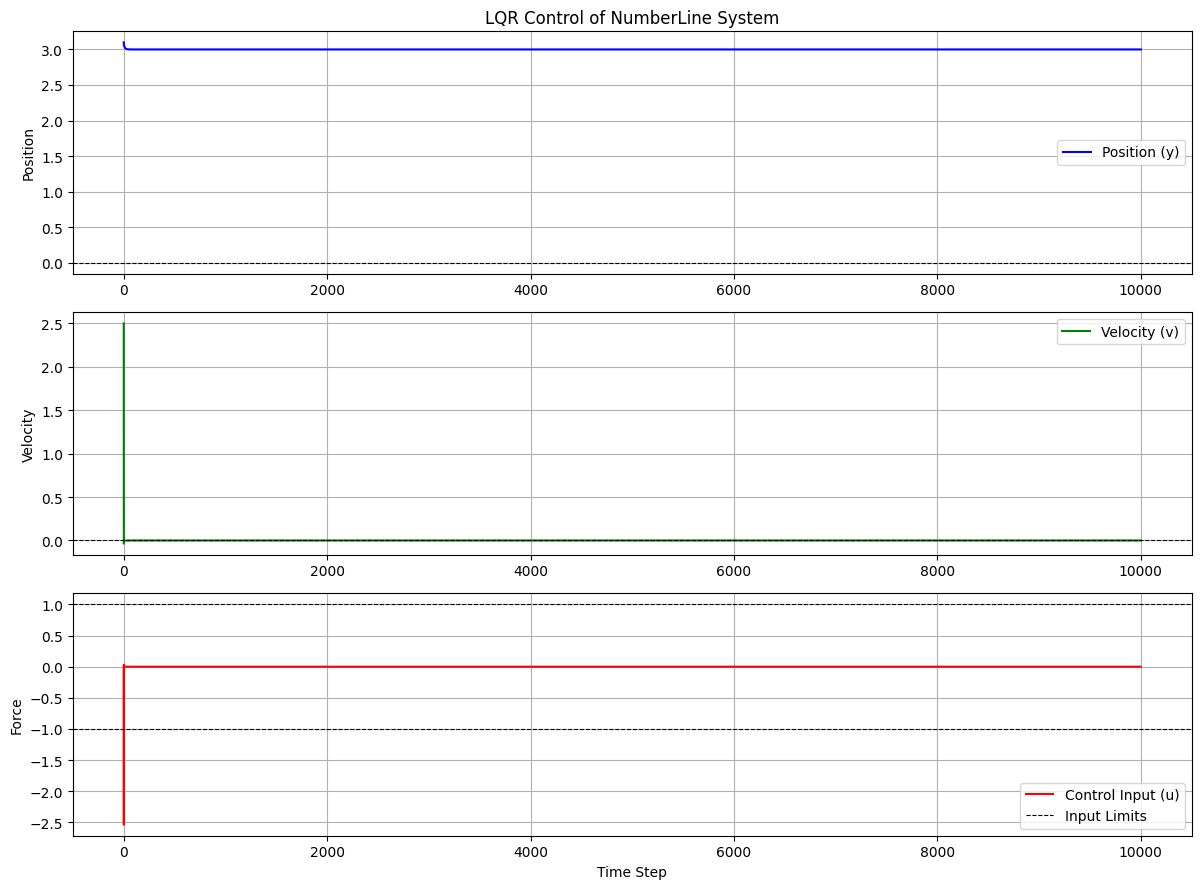

In [77]:
# --- Simulation with the LQR Controller ---

# Instantiate the system
system = NumberLineSystem(y0=3.1, v0=2.5, y_max=10, v_max=10, A=0, noise=True)
x_d = np.array([3.0, 0.0]) # Desired state
steps = 10_000

# Run the closed-loop simulation
for t in range(steps):
    # Get current state
    current_x = np.array([system.y, system.v])

    # Calculate control input using LQR gain
    u = -K @ (current_x - x_d)

    # The system's step function will automatically clamp the input
    system.step(u[0])

# --- 4. Results ---

# Save the simulation history to a CSV file
history_df = pd.DataFrame(system.history)
history_df.to_csv('lqr_numberline_simulation.csv', index=False)
print("\nSimulation complete. Results saved to 'lqr_numberline_simulation.csv'")

# Display the first steps of the simulation
print(history_df.head(steps))

# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(history_df['y'], label='Position (y)', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('LQR Control of NumberLine System')
plt.ylabel('Position')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(history_df['v'], label='Velocity (v)', color='green')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.ylabel('Velocity')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(history_df['u'], label='Control Input (u)', color='red')
plt.axhline(1, color='black', linestyle='--', linewidth=0.8, label='Input Limits')
plt.axhline(-1, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Time Step')
plt.ylabel('Force')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()